In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from IPython.utils import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class GA:

    def __init__(self,
                 chromosome_size,
                 fitness_func,
                 num_generations = 50, 
                 pop_size = 50, 
                 p_c = 0.9,
                 p_m = 0.1, 
                 min_features = 5,
                 max_features = 12, 
                 keep_best = 10
                 ):
        
        self.num_generations = num_generations
        self.pop_size = pop_size
        self.p_c = p_c
        self.p_m = p_m
        self.chromosome_size = chromosome_size
        self.min_features = min_features
        self.max_features = max_features 
        self.keep_best = keep_best # number of best chromosomes to be kept for next generation(These chromosomes will not undergo mutation or cross-over)
        self.fitness_func = fitness_func


        self.population = self.initialize_population()
        self.best_fitness = 0
        self.best_chromosome = None
        self.best_fitness_generation = [] #generation-wise best fitness
        self.best_chromosome_generation = [] #generation-wise best fitness

    def initialize_population(self):
        initial_population = np.zeros((self.pop_size, self.chromosome_size))
        for i in range(len(initial_population)):
            initial_population[i][:random.randint(5, 12)] = 1
            np.random.shuffle(initial_population[i])

        return initial_population

    def run(self):
        for generation in range(self.num_generations):
            # Measuring the fitness of each chromosome in the population.
            fitness = self.cal_pop_fitness()

            # Selecting the best parents in the population for mating.
            parents = self.roulette_wheel_selection(fitness, num_parents=(self.pop_size - self.keep_best))

            # Generating next generation using uniform crossover.
            offspring_crossover = self.uniform_crossover(parents)

            # Adding some variations to the offspring using mutation.
            offspring_mutation = self.inversion_mutation(offspring_crossover)

            
            parents_to_keep = self.steady_state_selection(fitness, num_parents=self.keep_best)
            self.population[0:parents_to_keep.shape[0], :] = parents_to_keep
            self.population[parents_to_keep.shape[0]:, :] = offspring_mutation

            # print("iteration",generation," Accuracy: ",self.best_fitness)



        return self.best_fitness_generation, self.best_chromosome_generation


    def cal_pop_fitness(self):

        pop_fitness = []
        # Calculating the fitness value of each solution(chromosome) in the current population.
        for sol in self.population:
            fitness = self.fitness_func(sol)
            pop_fitness.append(fitness)
        
        pop_fitness = np.array(pop_fitness)

        

        if self.best_fitness < np.max(pop_fitness):
            self.best_chromosome =  self.population[np.where(pop_fitness == np.max(fitness))][0]
            self.best_fitness = np.max(pop_fitness)

        # The best result upto the current iteration.
        self.best_fitness_generation.append(self.best_fitness)
        self.best_chromosome_generation.append(self.best_chromosome)

        return pop_fitness


    def roulette_wheel_selection(self, fitness, num_parents):
        fitness_sum = np.sum(fitness)
        probs = fitness / fitness_sum
        probs_start = np.zeros(probs.shape, dtype=np.float) # An array holding the start values of the ranges of probabilities.
        probs_end = np.zeros(probs.shape, dtype=np.float) # An array holding the end values of the ranges of probabilities.
        curr = 0.0

        # Calculating the probabilities of the solutions to form a roulette wheel.
        for _ in range(probs.shape[0]):
            min_probs_idx = np.where(probs == np.min(probs))[0][0]
            probs_start[min_probs_idx] = curr
            curr = curr + probs[min_probs_idx]
            probs_end[min_probs_idx] = curr
            probs[min_probs_idx] = 99999999999

        # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            rand_prob = np.random.rand()
            for idx in range(probs.shape[0]):
                if (rand_prob >= probs_start[idx] and rand_prob < probs_end[idx]):
                    parents[parent_num, :] = self.population[idx, :]
                    break
        return parents   


    def uniform_crossover(self, parents):
        offspring_crossover = parents
        for i in range(int(len(offspring_crossover)/2)):
            if random.uniform(0, 1) < self.p_c:  
                cross_over_sites = random.sample(range(self.chromosome_size), random.randint(0, int(self.chromosome_size/2)))
                offspring_crossover[i*2][cross_over_sites], offspring_crossover[i*2+1][cross_over_sites] = offspring_crossover[i*2+1][cross_over_sites], offspring_crossover[i*2][cross_over_sites]
        
        return offspring_crossover



    def inversion_mutation(self, offspring):
        #Applies the inverse mutation which selects a subset of genes and invert them.
        
        for i in range(len(offspring)):
            if random.uniform(0, 1) < self.p_m:  
                mutation_start = random.randint(0,self.chromosome_size-2)#np.random.randint(low=0, high=np.ceil(offspring.shape[1]/2 + 1), size=1)[0]
                mutation_end = random.randint(mutation_start + 2,self.chromosome_size)#mutation_start + int(offspring.shape[1]/2)

                
                offspring[i, mutation_start:mutation_end] = np.flip(offspring[i, mutation_start:mutation_end])
        return offspring


    def steady_state_selection(self, fitness, num_parents):
        fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
        fitness_sorted.reverse()
        # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        parents = np.empty((num_parents, self.population.shape[1]))
        for parent_num in range(num_parents):
            parents[parent_num, :] = self.population[fitness_sorted[parent_num], :]
        return parents


    

In [0]:
def compute_gini_feature(feature):#for computing gini of an attribute
    probs = feature.value_counts(normalize=True)
    return 1 - np.sum(np.square(probs))

def compute_gini(X, y, numeric_attributes):
    gini_index = {} #gini index of all features will be stored in this dictionary
    
    
    for  feature in X.columns:
        feature_levels = np.sort(X[feature].unique())
        for i in range(0,len(feature_levels)):
            if feature not in numeric_attributes:
                data_split_1 = X[feature] == feature_levels[i]
                data_split_2 = X[feature] != feature_levels[i]

            else:
                if i==0:
                    continue
                data_split_1 = X[feature] < ((feature_levels[i-1]+feature_levels[i])/2)
                data_split_2 = X[feature] >= ((feature_levels[i-1]+feature_levels[i])/2)

            gini_split_1 = compute_gini_feature(y[data_split_1])
            gini_split_2 = compute_gini_feature(y[data_split_2])

            gini_feature_split = len(y[data_split_1])/len(y)*gini_split_1 + len(y[data_split_2])/len(y)*gini_split_2#gini index of a particular feature for a particular split
            gini_index[feature] = min(gini_feature_split, gini_index.get(feature,1))

    return gini_index

In [0]:
def compute_info_gain_feature(feature):#for computing info_gain of an attribute
    probs = feature.value_counts(normalize=True)
    return -1 * np.sum(np.log2(probs) * probs)

def compute_info_gain(X, y):
    info_gain = {} #info_gain of all features will be stored in this dictionary
    target_entropy = compute_info_gain_feature(y)

    for  feature in X.columns:
        entropy_list = list()
        weight_list = list()

        feature_levels = np.sort(X[feature].unique())
        for i in range(0,len(feature_levels)):
            indices_feature_level = X[feature] == feature_levels[i]
            entropy_level = compute_info_gain_feature(y[indices_feature_level])
            entropy_list.append(round(entropy_level, 4))
            weight_level = len(y[indices_feature_level]) / len(y)
            weight_list.append(round(weight_level, 4))

        info_gain[feature] = target_entropy - np.sum(np.array(entropy_list) * np.array(weight_list))

    return info_gain

In [0]:
def compute_gain_ratio(X, y, info_gain):
    gain_ratio = {} #gain_ratio of all features will be stored in this dictionary

    for  feature in X.columns:
        
        split_info_list = list()

        feature_levels = np.sort(X[feature].unique())
        for i in range(0,len(feature_levels)):
            indices_feature_level = X[feature] == feature_levels[i]

            split_info_level = -1 * ( len(y[indices_feature_level]) / len(y) ) * math.log2( len(y[indices_feature_level]) / len(y) )
            split_info_list.append(round(split_info_level, 4))

        gain_ratio[feature] = info_gain[feature] / np.sum(np.array(split_info_list))

    return gain_ratio

In [0]:
data = pd.read_excel('https://github.com/NAshwinKumar/credit_risk_assessment/raw/master/GermanCredit.xls', sheet_name='Data')

# Exploratory Data Analysis and Pre-processing

In [16]:
print ('\033[1m' + "Number of Rows     : " +'\033[0m',data.shape[0])
print ('\033[1m' + "\nNumber of Columns  : " +'\033[0m',data.shape[1])
print ('\033[1m' + "\nMissing values     :  "+'\033[0m', data.isnull().values.any(),'\n')
min_val = data.min()
min_val[data.select_dtypes(include='object').columns] = np.nan

max_val = data.max()
max_val[data.select_dtypes(include='object').columns] = np.nan

eda_data = { 'Data Type' : data.dtypes, '#Unique Values' : data.nunique(), 'Min Value' : min_val, 'Max Value' : max_val}
pd.DataFrame(eda_data)


Number of Rows     :  1000

Number of Columns  :  32

Missing values     :   False 



,Data Type,#Unique Values,Min Value,Max Value
OBS#,int64,1000,1.0,1000.0
CHK_ACCT,int64,4,0.0,3.0
DURATION,int64,33,4.0,72.0
HISTORY,int64,5,0.0,4.0
NEW_CAR,int64,2,0.0,1.0
USED_CAR,int64,2,0.0,1.0
FURNITURE,int64,2,0.0,1.0
RADIO/TV,int64,2,0.0,1.0
EDUCATION,int64,2,0.0,1.0
RETRAINING,int64,2,0.0,1.0


In [0]:
eda_df.to_csv("/content/drive/My Drive/soft_package/EDA.csv")

In [0]:
data = data.drop(['OBS#'], axis=1)

## Min-max normalisation

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(data.iloc[:,:-1]) 
data.iloc[:,:-1] = scaled_values

In [0]:
data

,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO/TV,EDUCATION,RETRAINING,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,MALE_DIV,MALE_SINGLE,MALE_MAR_or_WID,CO-APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,0.000000,0.029412,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.050567,1.00,1.00,1.000000,0.0,1.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.857143,0.0,0.0,1.0,0.333333,0.666667,0.0,1.0,0.0,1
1,0.333333,0.647059,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.313690,0.00,0.50,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.053571,0.0,0.0,1.0,0.000000,0.666667,0.0,0.0,0.0,0
2,1.000000,0.117647,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.101574,0.00,0.75,0.333333,0.0,1.0,0.0,0.0,0.0,0.666667,1.0,0.0,0.535714,0.0,0.0,1.0,0.000000,0.333333,1.0,0.0,0.0,1
3,0.000000,0.558824,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.419941,0.00,0.75,0.333333,0.0,1.0,0.0,0.0,1.0,1.000000,0.0,0.0,0.464286,0.0,0.0,0.0,0.000000,0.666667,1.0,0.0,0.0,1
4,0.000000,0.294118,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.254209,0.00,0.50,0.666667,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.607143,0.0,0.0,0.0,0.333333,0.666667,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.117647,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.081765,0.00,0.75,0.666667,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.214286,0.0,0.0,1.0,0.000000,0.333333,0.0,0.0,0.0,1
996,0.000000,0.382353,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.198470,0.00,0.50,1.000000,1.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.375000,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1
997,1.000000,0.117647,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.030483,0.00,1.00,1.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.339286,0.0,0.0,1.0,0.000000,0.666667,0.0,0.0,0.0,1
998,0.000000,0.602941,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.087763,0.00,0.50,1.000000,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.071429,0.0,0.0,0.0,0.000000,0.666667,0.0,1.0,0.0,0


In [0]:
numeric_attributes = ['DURATION','AMOUNT', 'INSTALL_RATE', 'AGE', 'NUM_CREDITS', 'NUM_DEPENDENTS']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('RESPONSE',axis=1),data['RESPONSE'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

#Feature Selection

# Features selected using Prior Knowledge

In [0]:
selected_features_indices_knowledge = [2, 3, 4, 5, 12, 14, 15, 16, 19, 21, 22, 29, 31]

selected_features_knowledge = data.columns[[i-2 for i in selected_features_indices_knowledge]]
print("Features selected using Prior Knowledge:", selected_features_knowledge)
print("Indices of features selected using Prior Knowledge:", selected_features_indices_knowledge)

Features selected using Prior Knowledge: Index(['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'SAV_ACCT',
       'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE', 'GUARANTOR', 'REAL_ESTATE',
       'PROP_UNKN_NONE', 'NUM_DEPENDENTS', 'FOREIGN'],
      dtype='object')
Indices of features selected using Prior Knowledge: [2, 3, 4, 5, 12, 14, 15, 16, 19, 21, 22, 29, 31]


# Feature selection using Gini index

In [0]:
gini_index = compute_gini(data.drop('RESPONSE',axis=1),data['RESPONSE'], numeric_attributes)
gini_index_sorted = sorted(gini_index.items(), key=lambda x: x[1])#[:2]
selected_features_gini = [i[0] for i in gini_index_sorted[:12]]
print("Features selected using gini index:", selected_features_gini)

selected_features_indices_gini = [data.columns.get_loc(c) for c in selected_features_gini if c in data]
selected_features_indices_gini.sort()
selected_features_indices_gini = [i+2 for i in selected_features_indices_gini]
print("Indices of features selected using gini index:", selected_features_indices_gini)

Features selected using gini index: ['CHK_ACCT', 'HISTORY', 'DURATION', 'AMOUNT', 'SAV_ACCT', 'OWN_RES', 'AGE', 'PROP_UNKN_NONE', 'REAL_ESTATE', 'OTHER_INSTALL', 'RADIO/TV', 'EMPLOYMENT']
Indices of features selected using gini index: [2, 3, 4, 8, 11, 12, 13, 21, 22, 23, 24, 26]


# Feature selection using Info Gain

In [0]:
info_gain = compute_info_gain(data.drop('RESPONSE',axis=1),data['RESPONSE'])
info_gain_sorted = sorted(info_gain.items(), key=lambda x: x[1], reverse=True)
selected_features_info_gain = [i[0] for i in info_gain_sorted[:12]]
print("Features selected using info_gain:", selected_features_info_gain)

selected_features_indices_info_gain = [data.columns.get_loc(c) for c in selected_features_info_gain if c in data]
selected_features_indices_info_gain.sort()
selected_features_indices_info_gain = [i+2 for i in selected_features_indices_info_gain]
print("Indices of features selected using info_gain:", selected_features_indices_info_gain)

Features selected using info_gain: ['AMOUNT', 'CHK_ACCT', 'DURATION', 'AGE', 'HISTORY', 'SAV_ACCT', 'EMPLOYMENT', 'OWN_RES', 'PROP_UNKN_NONE', 'REAL_ESTATE', 'OTHER_INSTALL', 'RADIO/TV']
Indices of features selected using info_gain: [2, 3, 4, 8, 11, 12, 13, 21, 22, 23, 24, 26]


# Feature selection using Gain Ratio

In [0]:
gain_ratio = compute_gain_ratio(data.drop('RESPONSE',axis=1),data['RESPONSE'],info_gain)
gain_ratio_sorted = sorted(gain_ratio.items(), key=lambda x: x[1], reverse=True)
selected_features_gain_ratio = [i[0] for i in gain_ratio_sorted[:12]]
print("Features selected using gain_ratio:", selected_features_gain_ratio)

selected_features_indices_gain_ratio = [data.columns.get_loc(c) for c in selected_features_gain_ratio if c in data]
selected_features_indices_gain_ratio.sort()
selected_features_indices_gain_ratio = [i+2 for i in selected_features_indices_gain_ratio]
print("Indices of features selected using gain_ratio:", selected_features_indices_gain_ratio)

Features selected using gain_ratio: ['AMOUNT', 'CHK_ACCT', 'FOREIGN', 'HISTORY', 'PROP_UNKN_NONE', 'DURATION', 'SAV_ACCT', 'USED_CAR', 'OWN_RES', 'OTHER_INSTALL', 'REAL_ESTATE', 'EDUCATION']
Indices of features selected using gain_ratio: [2, 3, 4, 6, 9, 11, 12, 21, 22, 24, 26, 31]


# Feature selection using Correlation

Features selected using Correlation: ['CHK_ACCT', 'HISTORY', 'DURATION', 'SAV_ACCT', 'AMOUNT', 'OWN_RES', 'PROP_UNKN_NONE', 'REAL_ESTATE', 'EMPLOYMENT', 'OTHER_INSTALL', 'RADIO/TV', 'USED_CAR']
Indices of features selected using Correlation: [3, 4, 5, 7, 9, 12, 13, 14, 22, 23, 25, 27]


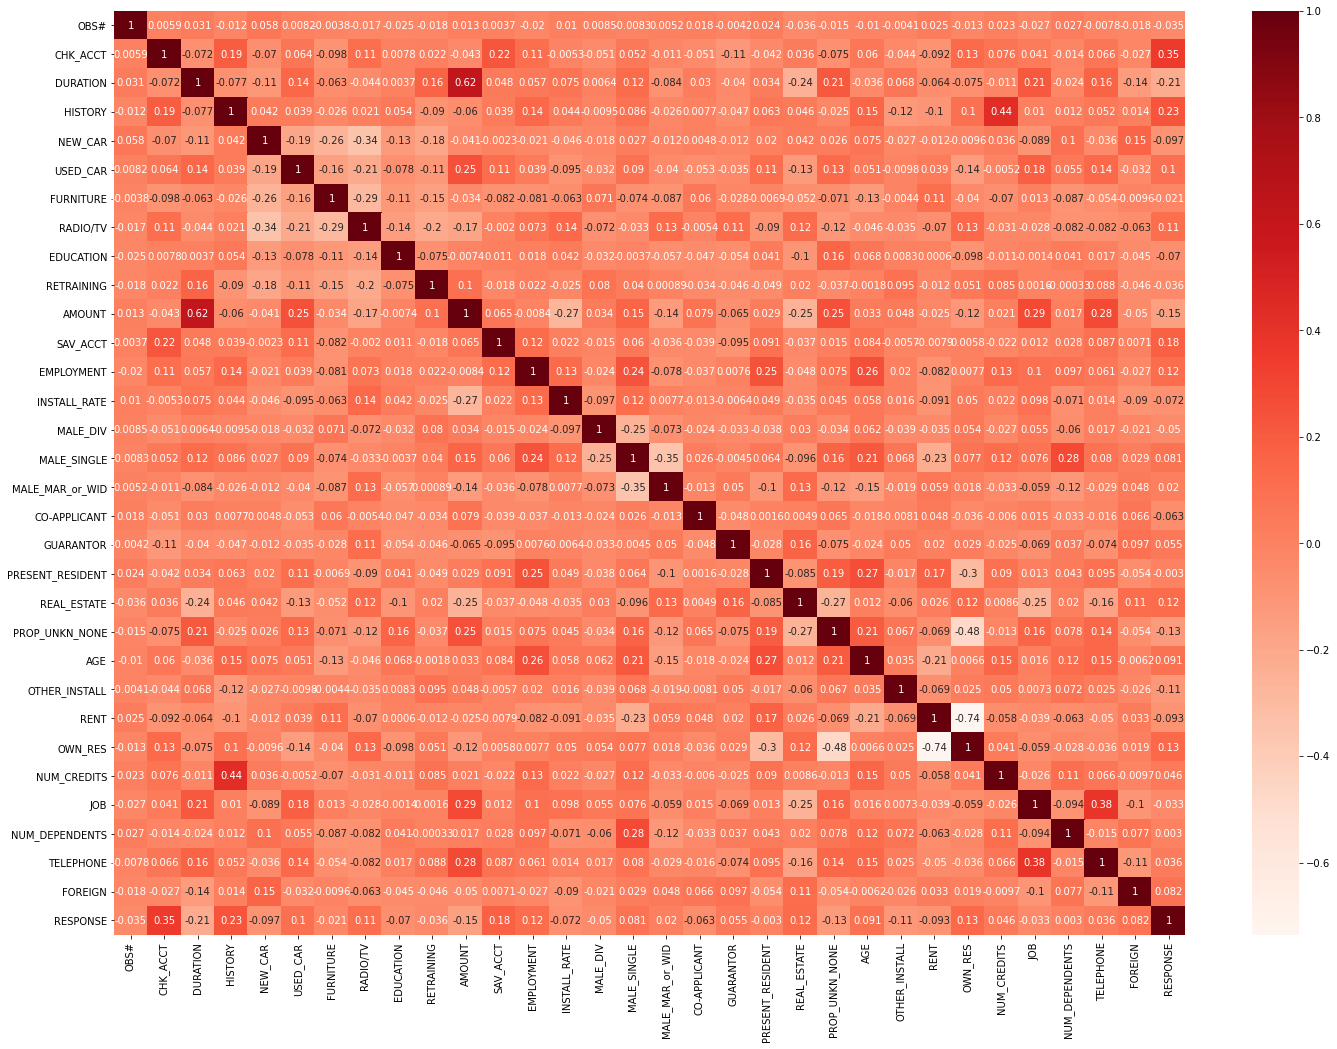

In [15]:
cor = data.corr()
cor_target = abs(cor["RESPONSE"])

selected_features_cor = cor_target.sort_values(ascending=False)[:13].index.values
selected_features_cor = np.delete(selected_features_cor,0).tolist()
print("Features selected using Correlation:",selected_features_cor)


selected_features_indices_cor = [data.columns.get_loc(c) for c in selected_features_cor if c in data]
selected_features_indices_cor.sort()
selected_features_indices_cor = [i+2 for i in selected_features_indices_cor]
print("Indices of features selected using Correlation:", selected_features_indices_cor)


plt.figure(figsize=(24,17))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
# plt.savefig('/content/drive/My Drive/soft_package/correlation_matrix.png')

In [14]:
plt.savefig('/content/drive/My Drive/soft_package/correlation_matrix.png')

<Figure size 432x288 with 0 Axes>

# Union of features selected

In [0]:
selected_features = list(set().union(selected_features_knowledge, selected_features_gini, selected_features_info_gain, selected_features_gain_ratio, selected_features_cor))
print("Features selected:",selected_features)


selected_features_indices = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features_indices.sort()
selected_features_indices = [i+2 for i in selected_features_indices]
print("Indices of features selected:", selected_features_indices)

Features selected: ['EDUCATION', 'NUM_DEPENDENTS', 'AGE', 'REAL_ESTATE', 'GUARANTOR', 'MALE_DIV', 'EMPLOYMENT', 'PROP_UNKN_NONE', 'NEW_CAR', 'DURATION', 'AMOUNT', 'CHK_ACCT', 'USED_CAR', 'RADIO/TV', 'OWN_RES', 'FOREIGN', 'SAV_ACCT', 'INSTALL_RATE', 'MALE_SINGLE', 'HISTORY', 'OTHER_INSTALL']
Indices of features selected: [2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 19, 21, 22, 23, 24, 26, 29, 31]


In [0]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_val = X_val[selected_features]

# Feature Selection using Gentic Algorithm

In [0]:
def fitness_func(chromosome):

    labels = X_train.columns
    indices = [i for i, x in enumerate(chromosome) if x == 1]
    selected_features_chromosome = [labels[i] for i in indices]

    
    mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                        solver='sgd', verbose=10, random_state=1,
                        learning_rate_init=.1)
    
    with io.capture_output() as captured:
        mlp = mlp.fit(X_train[selected_features_chromosome], y_train);
    

    y_pred = mlp.predict(X_val[selected_features_chromosome])
    return accuracy_score(y_val, y_pred)

In [0]:
best_fitness_generation_execution = [] # GA is executed multiple times, For each execution we will get a list which will contain the best accuracy at each generation. This list is appended to best_fitness_generation_execution
best_chromosome_generation_execution = [] 

for execution_num in range(10):
    ga = GA(num_generations = 50, pop_size = 50, p_c = 0.9, p_m = 0.05, chromosome_size = X_train.shape[1], min_features = 1, max_features = X_train.shape[1]-1, keep_best = 10, fitness_func=fitness_func)
    best_fitness_generation, best_chromosome_generation = ga.run()

    best_fitness_generation.insert(0, "Execution"+str(execution_num+1))
    best_fitness_generation_execution.append(best_fitness_generation)

    best_chromosome_generation.insert(0, "Execution"+str(execution_num+1))
    best_chromosome_generation_execution.append(best_chromosome_generation)


cols = list(range(len(best_fitness_generation_execution[0])))
cols[0] = 'Execution#'
best_fitness_generation_execution_df = pd.DataFrame(best_fitness_generation_execution, columns = cols)
best_fitness_generation_execution_df = best_fitness_generation_execution_df.append(best_fitness_generation_execution_df.mean(numeric_only=True), ignore_index=True)
best_fitness_generation_execution_df.iloc[-1,0] = "Mean"
new_names = [(i,'Generation_'+str(i)) for i in best_fitness_generation_execution_df.iloc[:, 1:].columns.values]
best_fitness_generation_execution_df.rename(columns = dict(new_names), inplace=True)


best_chromosome_generation_execution_df = pd.DataFrame(best_chromosome_generation_execution, columns = cols)


In [0]:
best_fitness_generation_execution_df[['Execution#', 'Generation_1', 'Generation_2', 'Generation_5', 'Generation_10', 'Generation_25', 'Generation_50']]

,Execution#,Generation_1,Generation_2,Generation_5,Generation_10,Generation_25,Generation_50
0,Execution1,0.785,0.7850,0.7850,0.805,0.825,0.8450
1,Execution2,0.790,0.7900,0.8050,0.810,0.835,0.8350
2,Execution3,0.795,0.8050,0.8300,0.830,0.835,0.8350
3,Execution4,0.790,0.7900,0.7900,0.805,0.820,0.8350
4,Execution5,0.790,0.7900,0.8050,0.810,0.820,0.8350
5,Execution6,0.795,0.7950,0.7950,0.795,0.805,0.8050
6,Execution7,0.795,0.7950,0.7950,0.820,0.835,0.8350
7,Execution8,0.795,0.7950,0.7950,0.810,0.815,0.8300
8,Execution9,0.795,0.8000,0.8150,0.815,0.840,0.8400
9,Execution10,0.810,0.8100,0.8100,0.810,0.830,0.8300


# Feature Selection Using Bat Algorithm

In [0]:
class BatAlgorithm():
    def __init__(self, D, NP, N_Gen, A, r, Qmin, Qmax, function):# Lower, Upper
        self.D = D  #dimension
        self.NP = NP  #population size 
        self.N_Gen = N_Gen  #generations
        self.A = A  #loudness
        self.r = r  #pulse rate
        self.Qmin = Qmin  #frequency min
        self.Qmax = Qmax  #frequency max

        self.f_max = 0  #minimum fitness
        
        self.Q = [0] * self.NP  #frequency

        self.v = [[0 for i in range(self.D)] for j in range(self.NP)]  #velocity
        self.Sol = [[0 for i in range(self.D)] for j in range(self.NP)]  #population of solutions
        self.Fitness = [0] * self.NP  #fitness
        self.best = [0] * self.D  #best solution
        self.Fitnessfun = function
        self.best_fitness_generation = []


    def best_bat(self):
        i = 0
        j = 0
        for i in range(self.NP):
            if self.Fitness[i] < self.Fitness[j]:
                j = i
        for i in range(self.D):
            self.best[i] = self.Sol[j][i]
        self.f_max = self.Fitness[j]

    def init_bat(self):

        for i in range(self.NP):
            self.Q[i] = 0
            for j in range(self.D):
                self.v[i][j] = 0.0
                self.Sol[i][j] =  random.randint(0,1)
            self.Fitness[i] = self.Fitnessfun(self.Sol[i])
        self.best_bat()

    def simplebounds(self, val):
        v = 0
        try:
            if val < -100:
                val = -100
            sig = random.randint(0,1)
            if sig < (1/(1+math.exp(-1*val))):
                v = 1
            else:
                v = 0
        except OverflowError:
	        print(val)
        return v
    def move_bat(self):
        S = [[0.0 for i in range(self.D)] for j in range(self.NP)]

        self.init_bat()

        for t in range(self.N_Gen):
            for i in range(self.NP):
                rnd = np.random.uniform(0, 1)
                self.Q[i] = self.Qmin + (self.Qmax - self.Qmin) * rnd
                for j in range(self.D):
                    self.v[i][j] = self.v[i][j] + (self.Sol[i][j] -
                                                   self.best[j]) * self.Q[i]
                    S[i][j] = self.Sol[i][j] + self.v[i][j]

                    S[i][j] = self.simplebounds(S[i][j])

                rnd = np.random.random_sample()

                if rnd > self.r:
                    for j in range(self.D):
                        S[i][j] = self.best[j] + 0.001 * random.gauss(0, 1)

                        S[i][j] = self.simplebounds(S[i][j])
                        
                Fnew = self.Fitnessfun(S[i])

                rnd = np.random.random_sample()

                if (Fnew >= self.Fitness[i]) and (rnd < self.A):
                    for j in range(self.D):
                        self.Sol[i][j] = S[i][j]
                    self.Fitness[i] = Fnew
                    self.A *= 0.5

                    

                if Fnew >= self.f_max:
                    for j in range(self.D):
                        self.best[j] = S[i][j]
                    self.f_max = Fnew


            self.best_fitness_generation.append(self.f_max)

        return self.best, self.best_fitness_generation

In [0]:
best_fitness_generation_execution_bat = []

for execution_num in range(10):
    Algorithm = BatAlgorithm(X_train.shape[1], 50, 50, 0.5, 0.5, 0.0, 2.0, fitness_func)
    selected_features_indices_bat, best_fitness_generation_bat = Algorithm.move_bat()

    best_fitness_generation_bat.insert(0, "Execution"+str(execution_num+1))
    best_fitness_generation_execution_bat.append(best_fitness_generation_bat)


cols = list(range(len(best_fitness_generation_execution_bat[0])))
cols[0] = 'Execution#'
best_fitness_generation_execution_bat_df = pd.DataFrame(best_fitness_generation_execution_bat, columns = cols)
best_fitness_generation_execution_bat_df = best_fitness_generation_execution_bat_df.append(best_fitness_generation_execution_bat_df.mean(numeric_only=True), ignore_index=True)
best_fitness_generation_execution_bat_df.iloc[-1,0] = "Mean"
new_names = [(i,'Generation_'+str(i)) for i in best_fitness_generation_execution_bat_df.iloc[:, 1:].columns.values]
best_fitness_generation_execution_bat_df.rename(columns = dict(new_names), inplace=True)

In [0]:
best_fitness_generation_execution_bat_df[['Execution#', 'Generation_1', 'Generation_2', 'Generation_5', 'Generation_10', 'Generation_25', 'Generation_50']]

,Execution#,Generation_1,Generation_2,Generation_5,Generation_10,Generation_25,Generation_50
0,Execution1,0.7900,0.8100,0.8100,0.810,0.815,0.8150
1,Execution2,0.8200,0.8200,0.8200,0.820,0.820,0.8200
2,Execution3,0.7900,0.7950,0.8250,0.825,0.825,0.8250
3,Execution4,0.8150,0.8150,0.8150,0.815,0.825,0.8250
4,Execution5,0.8200,0.8200,0.8200,0.820,0.820,0.8200
5,Execution6,0.7950,0.8000,0.8100,0.815,0.820,0.8350
6,Execution7,0.8000,0.8000,0.8200,0.820,0.820,0.8300
7,Execution8,0.7800,0.8200,0.8200,0.820,0.820,0.8200
8,Execution9,0.7950,0.7950,0.8000,0.830,0.830,0.8300
9,Execution10,0.7900,0.8000,0.8150,0.815,0.815,0.8150


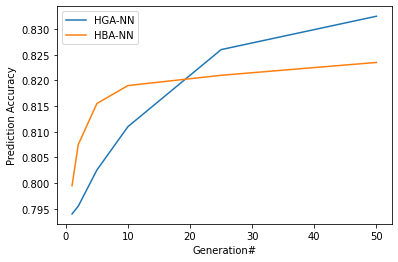

In [25]:
import matplotlib.pyplot as plt
plt.plot([1,2,5,10,25,50],[0.794, 0.7955, 0.80255,0.811,0.826, 0.8325], label = "HGA-NN")
plt.plot([1,2,5,10,25,50],[0.7995,0.8075, 0.8155,0.819,0.821,0.8235], label = "HBA-NN")
plt.xlabel("Generation#")
plt.ylabel("Prediction Accuracy")
# plt.savefig("reduce_plotting_time.png",dpi=250,bbox_inches="tight",pad_inches=0.02)
plt.legend() 
plt.show()